In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.Container {width:85% !important;}
div.CodeMirror {font-family:나눔고딕; font-size:13pt; line-height : 150%;}
div.output_area pre {font-family:나눔고딕; font-size:13pt; line-height : 150%;}
div.output_wrapper pre {font-family:나눔고딕; font-size:13pt; line-height : 150%;}
div.input {font-family:나눔고딕; font-size:13pt; line-height : 150%;}
</style>
"""))

# 딥러닝을 사용한 경기결과 예측
- 모델 두가지를 사용하여 정확도 및 결과 확인
- 선수 별이 아닌 팀 별 데이터가 필요

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential # 3. 모델 생성
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

## 다중분류

In [41]:
# ▶ 1. 데이터 셋 준비
df = pd.read_csv('D:/Gray_Bigdata/src/00_Projects/data/game_result/england-premier-league-matches-2020-to-2021-stats.csv')

In [42]:
df

,result,date,home_team_name,away_team_name,referee,home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,...,average_cards_per_match_pre_match,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no
0,L,Sep 12 2020 - 11:30am,Fulham,Arsenal,Chris Kavanagh,0.53,1.74,0,3,3,...,0.00,6.00,4.55,1.53,1.24,1.74,2.90,5.40,1.80,1.87
1,W,Sep 12 2020 - 2:00pm,Crystal Palace,Southampton,Jonathan Moss,1.21,0.84,1,0,1,...,0.00,3.20,3.30,2.50,1.38,2.15,4.00,8.00,1.83,1.83
2,W,Sep 12 2020 - 4:30pm,Liverpool,Leeds United,Michael Oliver,1.74,1.58,4,3,7,...,0.00,1.33,6.10,8.75,1.16,1.53,2.35,4.05,1.80,1.87
3,L,Sep 12 2020 - 7:00pm,West Ham United,Newcastle United,Stuart Attwell,1.79,1.16,0,2,2,...,0.00,1.91,3.85,4.35,1.27,1.87,3.20,6.10,1.71,1.95
4,L,Sep 13 2020 - 1:00pm,West Bromwich Albion,Leicester City,Anthony Taylor,0.79,2.00,0,3,3,...,0.00,3.85,3.65,1.95,1.30,1.95,3.40,6.55,1.77,1.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,W,May 23 2021 - 3:00pm,Liverpool,Crystal Palace,Craig Pawson,1.74,1.11,2,0,2,...,2.67,1.20,6.50,13.00,1.11,1.36,1.98,3.05,1.95,1.74
376,W,May 23 2021 - 3:00pm,Manchester City,Everton,Michael Oliver,2.16,1.95,5,0,5,...,3.00,1.33,5.25,8.00,1.19,1.61,2.68,4.05,1.74,1.95
377,W,May 23 2021 - 3:00pm,Sheffield United,Burnley,Kevin Friend,0.84,1.11,1,0,1,...,3.00,2.88,3.30,2.50,1.35,1.88,2.75,4.90,1.62,2.15
378,W,May 23 2021 - 3:00pm,West Ham United,Southampton,Martin Atkinson,1.79,0.84,3,0,3,...,3.11,1.70,3.80,5.00,1.22,1.76,3.25,4.45,1.62,2.15


In [5]:
df.columns

Index(['result', 'date', 'home_team_name', 'away_team_name', 'referee',
       'home_ppg', 'away_ppg', 'home_team_goal_count', 'away_team_goal_count',
       'total_goal_count', 'total_goals_at_half_time',
       'home_team_goal_count_half_time', 'away_team_goal_count_half_time',
       'home_team_corner_count', 'away_team_corner_count',
       'home_team_yellow_cards', 'home_team_red_cards',
       'away_team_yellow_cards', 'away_team_red_cards',
       'home_team_first_half_cards', 'home_team_second_half_cards',
       'away_team_first_half_cards', 'away_team_second_half_cards',
       'home_team_shots', 'away_team_shots', 'home_team_shots_on_target',
       'away_team_shots_on_target', 'home_team_shots_off_target',
       'away_team_shots_off_target', 'home_team_fouls', 'away_team_fouls',
       'home_team_possession', 'away_team_possession', 'team_a_xg',
       'team_b_xg', 'average_goals_per_match_pre_match',
       'btts_percentage_pre_match', 'over_15_percentage_pre_match',
    

In [43]:
# 필요 없는 열 삭제 및 변수 나누기
df.drop(columns=['date', 'home_team_name', 'away_team_name', 'referee', 'home_ppg', 'away_ppg',
                 'over_25_percentage_pre_match', 'over_35_percentage_pre_match',
                 'over_45_percentage_pre_match', 'over_15_HT_FHG_percentage_pre_match',
                 'over_05_HT_FHG_percentage_pre_match', 'over_15_2HG_percentage_pre_match',
                 'over_05_2HG_percentage_pre_match', 'average_corners_per_match_pre_match',
                 'average_cards_per_match_pre_match'], inplace=True)

In [175]:
# df.rename(columns={'home_team_goal_count' : 'HGoalCnt', 'away_team_goal_count' : 'AGoalCnt',
#                    'total_goal_count' : 'TgoalCnt'}, inplace=True)

In [44]:
gameResult_x = df.iloc[:, 1:].to_numpy()
gameResult_y = df.iloc[:, 0]

print('타겟변수y가 될 경기결과의 종류 :', gameResult_y.unique())

타겟변수y가 될 경기결과의 종류 : ['L' 'W' 'D']


In [45]:
# ▶ 2. 데이터 전처리
# 입력(독립)변수 라벨 인코딩
scaler = MinMaxScaler()
scaler.fit(gameResult_x)
gameResult_x = scaler.transform(gameResult_x)

# # 결과(타겟)변수 원-핫 인코딩(라벨링 전환) 후 numpy 배열로 변환
gameResult_y = pd.get_dummies(gameResult_y).to_numpy()

gameResult_y

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [46]:
# 훈련셋과 검증셋 나누기 ( 7 : 3 )
train_X, test_X, train_Y, test_Y = train_test_split(gameResult_x, gameResult_y, test_size = 0.3, 
                                                    random_state = 1)

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(266, 40) (266, 3) (114, 40) (114, 3)


In [47]:
# ▶ 3. 모델 구성
model = Sequential()
model.add(Input(40)) # input_dim만 지정되어 있는 레이어

model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 3, activation = 'softmax'))


# ▶ 4. 모델 학습과정 설정
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])


# ▶ 5. 모델 학습
earlyStopping = EarlyStopping(patience = 15, monitor = 'val_loss')
hist = model.fit(train_X, train_Y, epochs = 150, batch_size = 10,
                 verbose = 1, callbacks = [earlyStopping], validation_split = 0.2)

Epoch 1/150
22/22 [==============================] - 1s 13ms/step - loss: 1.0859 - accuracy: 0.4057 - val_loss: 1.0915 - val_accuracy: 0.3519
Epoch 2/150
22/22 [==============================] - 0s 2ms/step - loss: 1.0392 - accuracy: 0.5283 - val_loss: 1.0373 - val_accuracy: 0.5741
Epoch 3/150
22/22 [==============================] - 0s 2ms/step - loss: 0.9986 - accuracy: 0.5755 - val_loss: 1.0277 - val_accuracy: 0.5556
Epoch 4/150
22/22 [==============================] - 0s 2ms/step - loss: 0.9621 - accuracy: 0.6132 - val_loss: 0.9860 - val_accuracy: 0.5926
Epoch 5/150
22/22 [==============================] - 0s 2ms/step - loss: 0.9186 - accuracy: 0.6651 - val_loss: 0.9371 - val_accuracy: 0.6852
Epoch 6/150
22/22 [==============================] - 0s 2ms/step - loss: 0.8662 - accuracy: 0.6934 - val_loss: 0.9081 - val_accuracy: 0.6296
Epoch 7/150
22/22 [==============================] - 0s 2ms/step - loss: 0.8060 - accuracy: 0.7264 - val_loss: 0.8662 - val_accuracy: 0.6296
Epoch 8/150


22/22 [==============================] - 0s 2ms/step - loss: 0.1556 - accuracy: 0.9481 - val_loss: 0.2330 - val_accuracy: 0.9259
Epoch 58/150
22/22 [==============================] - 0s 2ms/step - loss: 0.1135 - accuracy: 0.9953 - val_loss: 0.1979 - val_accuracy: 0.9630
Epoch 59/150
22/22 [==============================] - 0s 2ms/step - loss: 0.1323 - accuracy: 0.9811 - val_loss: 0.2024 - val_accuracy: 0.9444
Epoch 60/150
22/22 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.9670 - val_loss: 0.1982 - val_accuracy: 0.9444
Epoch 61/150
22/22 [==============================] - 0s 2ms/step - loss: 0.1205 - accuracy: 0.9717 - val_loss: 0.1845 - val_accuracy: 0.9630
Epoch 62/150
22/22 [==============================] - 0s 2ms/step - loss: 0.1109 - accuracy: 0.9953 - val_loss: 0.1903 - val_accuracy: 0.9630
Epoch 63/150
22/22 [==============================] - 0s 2ms/step - loss: 0.1079 - accuracy: 0.9953 - val_loss: 0.2071 - val_accuracy: 0.9444
Epoch 64/150
22/22 

Epoch 115/150
22/22 [==============================] - 0s 1ms/step - loss: 0.0288 - accuracy: 0.9953 - val_loss: 0.0690 - val_accuracy: 0.9815
Epoch 116/150
22/22 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9953 - val_loss: 0.0569 - val_accuracy: 1.0000
Epoch 117/150
22/22 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.0534 - val_accuracy: 0.9815
Epoch 118/150
22/22 [==============================] - 0s 2ms/step - loss: 0.0315 - accuracy: 0.9953 - val_loss: 0.0768 - val_accuracy: 0.9815
Epoch 119/150
22/22 [==============================] - 0s 2ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 0.0841 - val_accuracy: 0.9815
Epoch 120/150
22/22 [==============================] - 0s 2ms/step - loss: 0.0308 - accuracy: 0.9953 - val_loss: 0.0684 - val_accuracy: 0.9815
Epoch 121/150
22/22 [==============================] - 0s 2ms/step - loss: 0.0355 - accuracy: 0.9953 - val_loss: 0.0466 - val_accuracy: 1.0000

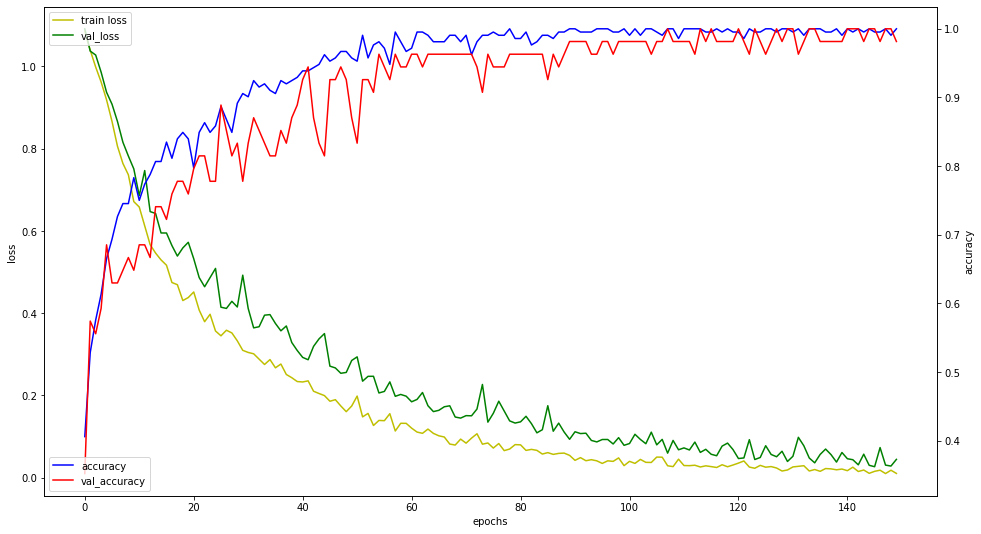

In [48]:
# ▶ 6. 모델 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize = (16, 9))

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label = 'val_loss')

loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label = 'accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'r', label = 'val_accuracy')

acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc = 'lower left')

plt.show()

In [49]:
# ▶ 7. 모델 평가
loss_and_acc = model.evaluate(test_X, test_Y)

print('Loss :', round(loss_and_acc[0]*100, 2), '%')
print('Accuracy :', round(loss_and_acc[1]*100, 2), '%')

4/4 [==============================] - 0s 2ms/step - loss: 0.0914 - accuracy: 0.9561
Loss : 9.14 %
Accuracy : 95.61 %


In [50]:
# 성능 지표 (crosstab)
pred = model.predict(test_X).argmax(axis = 1)
# pred = np.argmax(model.predict(test_X), axis = 1)+3

# real = test_Y.armax(axis = 1)+3
real = np.argmax(test_Y, axis = 1)

cross_tab = pd.crosstab(real, pred)
cross_tab.index.name = 'real'
cross_tab.columns.name = 'predict'

cross_tab

predict,0,1,2
real,,,
0,17,2,1
1,1,51,0
2,1,0,41


In [ ]:
##################################################################################
##################################################################################

In [28]:
test_df = pd.read_csv('D:/Gray_Bigdata/src/00_Projects/data/england-premier-league-matches-2021-to-2022-stats.csv')

test_df.head(10)

,timestamp,date_GMT,status,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),...,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name
0,1628881200,Aug 13 2021 - 7:00pm,complete,16479.0,Brentford,Arsenal,Michael Oliver,1,0.0,0.0,...,3.90,3.40,2.05,1.43,2.20,3.75,7.25,1.95,2.00,Brentford Community Stadium (Brentford- Middle...
1,1628940600,Aug 14 2021 - 11:30am,complete,NaN,Manchester United,Leeds United,Paul Tierney,1,0.0,0.0,...,1.62,4.15,5.25,1.25,1.69,2.60,4.55,1.71,2.25,Old Trafford (Manchester)
2,1628949600,Aug 14 2021 - 2:00pm,complete,NaN,Burnley,Brighton & Hove Albion,David Coote,1,0.0,0.0,...,3.20,3.00,2.31,1.43,2.35,4.40,8.25,2.10,1.83,Turf Moor (Burnley)
3,1628949600,Aug 14 2021 - 2:00pm,complete,NaN,Chelsea,Crystal Palace,Jonathan Moss,1,0.0,0.0,...,1.27,5.40,9.40,1.40,1.67,2.59,7.75,2.65,1.54,Stamford Bridge (London)
4,1628949600,Aug 14 2021 - 2:00pm,complete,NaN,Everton,Southampton,Andy Madley,1,0.0,0.0,...,1.84,3.65,3.85,1.47,1.85,3.20,8.00,2.10,1.83,Goodison Park (Liverpool)
5,1628949600,Aug 14 2021 - 2:00pm,complete,NaN,Leicester City,Wolverhampton Wanderers,Craig Pawson,1,0.0,0.0,...,1.57,3.80,5.60,1.33,1.95,3.85,7.50,2.15,1.80,King Power Stadium (Leicester- Leicestershire)
6,1628949600,Aug 14 2021 - 2:00pm,complete,20051.0,Watford,Aston Villa,Mike Dean,1,0.0,0.0,...,3.30,3.45,2.06,1.36,1.95,3.30,6.75,1.91,2.00,Vicarage Road (Watford)
7,1628958600,Aug 14 2021 - 4:30pm,complete,NaN,Norwich City,Liverpool,Andre Marriner,1,0.0,0.0,...,7.75,5.25,1.40,1.22,1.59,2.40,4.25,1.87,2.05,Carrow Road (Norwich- Norfolk)
8,1629032400,Aug 15 2021 - 1:00pm,complete,NaN,Newcastle United,West Ham United,Martin Atkinson,1,0.0,0.0,...,3.30,3.50,2.20,1.33,1.91,3.10,6.00,1.77,2.20,St. James' Park (Newcastle upon Tyne)
9,1629041400,Aug 15 2021 - 3:30pm,complete,NaN,Tottenham Hotspur,Manchester City,Anthony Taylor,1,0.0,0.0,...,5.75,4.00,1.62,1.33,1.95,3.20,6.25,2.05,1.87,Tottenham Hotspur Stadium (London)


In [29]:
new_test = test_df

In [30]:
print(test_df.columns.values)

['timestamp' 'date_GMT' 'status' 'attendance' 'home_team_name'
 'away_team_name' 'referee' 'Game Week' 'Pre-Match PPG (Home)'
 'Pre-Match PPG (Away)' 'home_ppg' 'away_ppg' 'home_team_goal_count'
 'away_team_goal_count' 'total_goal_count' 'total_goals_at_half_time'
 'home_team_goal_count_half_time' 'away_team_goal_count_half_time'
 'home_team_goal_timings' 'away_team_goal_timings'
 'home_team_corner_count' 'away_team_corner_count'
 'home_team_yellow_cards' 'home_team_red_cards' 'away_team_yellow_cards'
 'away_team_red_cards' 'home_team_first_half_cards'
 'home_team_second_half_cards' 'away_team_first_half_cards'
 'away_team_second_half_cards' 'home_team_shots' 'away_team_shots'
 'home_team_shots_on_target' 'away_team_shots_on_target'
 'home_team_shots_off_target' 'away_team_shots_off_target'
 'home_team_fouls' 'away_team_fouls' 'home_team_possession'
 'away_team_possession' 'team_a_xg' 'team_b_xg'
 'average_goals_per_match_pre_match' 'btts_percentage_pre_match'
 'over_15_percentage_pre_

In [24]:
new_test.drop(columns=['home_team_name', 'away_team_name', 'home_ppg', 
                                 'away_ppg',  'average_goals_per_match_pre_match', 'btts_percentage_pre_match',
                                 'over_15_percentage_pre_match', 'over_25_percentage_pre_match', 
                                 'over_35_percentage_pre_match', 'over_45_percentage_pre_match',
                                 'over_15_HT_FHG_percentage_pre_match', 'over_05_HT_FHG_percentage_pre_match',
                                 'over_15_2HG_percentage_pre_match', 'over_05_2HG_percentage_pre_match',
                                 'average_corners_per_match_pre_match', 'average_cards_per_match_pre_match'], inplace=True)

In [25]:
new_test.head(10)

,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,home_team_goal_count_half_time,away_team_goal_count_half_time,home_team_corner_count,away_team_corner_count,home_team_yellow_cards,home_team_red_cards,...,team_b_xg,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no
0,2,0,2,1,1,0,2,5,0,0,...,2.35,3.90,3.40,2.05,1.43,2.20,3.75,7.25,1.95,2.00
1,5,1,6,1,1,0,5,4,1,0,...,1.23,1.62,4.15,5.25,1.25,1.69,2.60,4.55,1.71,2.25
2,1,2,3,1,1,0,7,6,2,0,...,1.68,3.20,3.00,2.31,1.43,2.35,4.40,8.25,2.10,1.83
3,3,0,3,2,2,0,5,2,0,0,...,0.52,1.27,5.40,9.40,1.40,1.67,2.59,7.75,2.65,1.54
4,3,1,4,1,0,1,6,8,2,0,...,0.99,1.84,3.65,3.85,1.47,1.85,3.20,8.00,2.10,1.83
5,1,0,1,1,1,0,5,4,1,0,...,1.59,1.57,3.80,5.60,1.33,1.95,3.85,7.50,2.15,1.80
6,3,2,5,2,2,0,2,4,3,0,...,1.31,3.30,3.45,2.06,1.36,1.95,3.30,6.75,1.91,2.00
7,0,3,3,1,0,1,3,11,1,0,...,2.38,7.75,5.25,1.40,1.22,1.59,2.40,4.25,1.87,2.05
8,2,4,6,3,2,1,7,6,1,0,...,2.33,3.30,3.50,2.20,1.33,1.91,3.10,6.00,1.77,2.20
9,1,0,1,0,0,0,3,11,2,0,...,2.03,5.75,4.00,1.62,1.33,1.95,3.20,6.25,2.05,1.87
